<a href="https://colab.research.google.com/github/guscldns/TestProject/blob/main/0724/05_1_(practice)yolov1_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# yolov1_implementation

1. architecture
2. IOU
3. loss

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## Architecture

In [ ]:
# architecture_config = [
#     (7, 64, 2, 3), # 7*7, fillter = 64, strides = 2, padding이 한 면에 몇개가 들어가는지
#     "M",
#     (3, 192, 1, 1),
#     "M",
#     (1, 128, 1, 0),
#     (3, 256, 1, 1),
#     (1, 256, 1, 0),
#     (3, 512, 1, 1),
#     "M",
#     [(1, 256, 1, 0), (3, 512, 1, 1), 4], # [, 4] 4층
#     (1, 512, 1, 0),
#     (3, 1024, 1, 1),
#     "M",
#     [(1, 512, 1, 0), (3, 1024, 1, 1), 2],
#     (3, 1024, 1, 1),
#     (3, 1024, 2, 1),
#     (3, 1024, 1, 1),
#     (3, 1024, 1, 1),
# ]

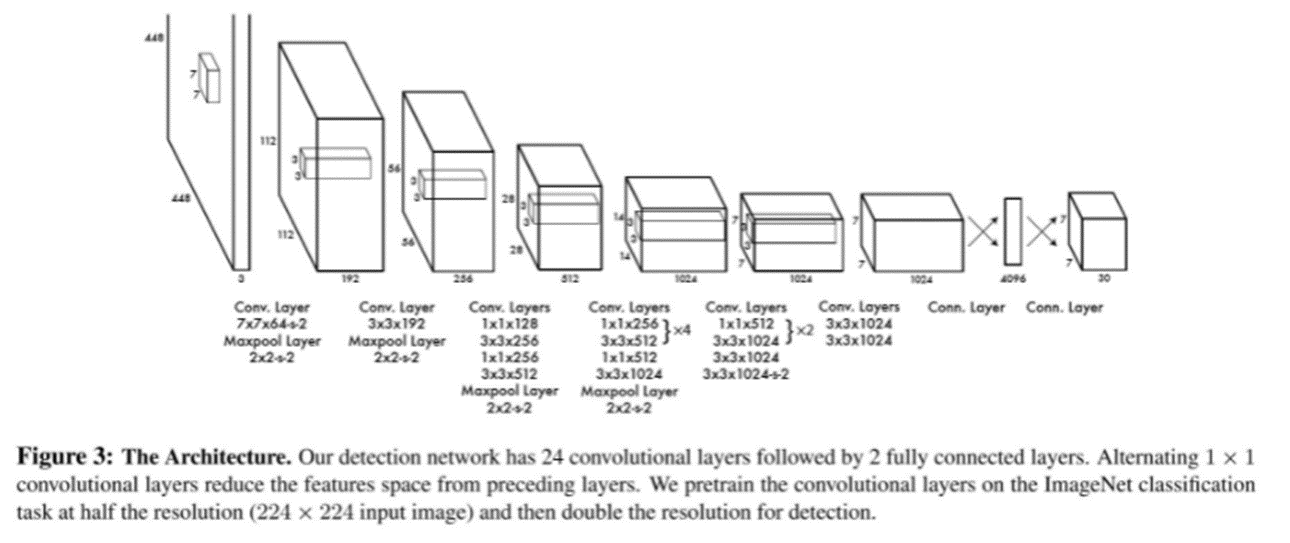

In [15]:
def yolo_v1(input_shape, num_classes, num_boxes):
    inputs = tf.keras.layers.Input(shape=input_shape)
    ############################################################################
    # 빈칸을 완성해보세요
    ############################################################################
    # First
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=7, strides=2, padding='same', activation='relu')(inputs)
    x = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)(x)

    # Second
    x = tf.keras.layers.Conv2D(filters=192, kernel_size=3, strides=1, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)(x)

    # Third
    x = tf.keras.layers.Conv2D(filters=128, kernel_size=1, strides=1, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=1, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(filters=256, kernel_size=1, strides=1, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(filters=512, kernel_size=3, strides=1, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)(x)

    # Fourth
    x = tf.keras.layers.Conv2D(filters=256, kernel_size=1, strides=1, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(filters=512, kernel_size=3, strides=1, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(filters=256, kernel_size=1, strides=1, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(filters=512, kernel_size=3, strides=1, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(filters=256, kernel_size=1, strides=1, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(filters=512, kernel_size=3, strides=1, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(filters=256, kernel_size=1, strides=1, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(filters=512, kernel_size=3, strides=1, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(filters=512, kernel_size=1, strides=1, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(filters=1024, kernel_size=3, strides=1, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)(x)

    # Fifth
    x = tf.keras.layers.Conv2D(filters=512, kernel_size=1, strides=1, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(filters=1024, kernel_size=3, strides=1, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(filters=512, kernel_size=1, strides=1, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(filters=1024, kernel_size=3, strides=1, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(filters=1024, kernel_size=3, strides=1, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(filters=1024, kernel_size=3, strides=2, padding='same', activation='relu')(x)

    # Sixth
    x = tf.keras.layers.Conv2D(filters=1024, kernel_size=3, strides=1, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(filters=1024, kernel_size=3, strides=1, padding='same', activation='relu')(x)

    # F.C
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(4096, activation='relu')(x)
    x = tf.keras.layers.Dense(7*7*30, activation='linear')(x)

    return tf.keras.Model(inputs=inputs, outputs= x)

In [16]:
model = yolo_v1([448,448,3], 20, 2)

In [17]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 448, 448, 3)]     0         
                                                                 
 conv2d_51 (Conv2D)          (None, 224, 224, 64)      9472      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 112, 112, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_52 (Conv2D)          (None, 112, 112, 192)     110784    
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 56, 56, 192)      0         
 g2D)                                                            
                                                                 
 conv2d_53 (Conv2D)          (None, 56, 56, 128)       2470

## IOU

#### tensorflow method 정리
- tf.math.maximum(a, b) : a, b 중 큰 값 리턴
- tf.math.minimum(a, b) : a, b 중 작은 값 리턴
- tf.math.abs(a) : a 절대값 리턴

In [ ]:
def iou(boxes_1, boxes_2, box_format="midpoint"):
    """
        박스 두개 입력받아서 두 박스의 iou 계산하여 return
    """
    ############################################################################
    # 빈칸을 완성해보세요
    ############################################################################
    # 1. calculate box_1 xmin, ymin, xmax, ymax
    ## x에서 w 절반을 빼면 x min, w의 절반을 더하면 x max
    box1_x1 = boxes_1[..., 0:1] - boxes_1[..., 2:3] / 2
    box1_y1 = boxes_1[..., 1:2] - boxes_1[..., 3:4] / 2
    box1_x2 = boxes_1[..., 0:1] + boxes_1[..., 2:3] / 2
    box1_y2 = boxes_1[..., 1:2] + boxes_1[..., 3:4] / 2

    # 2. calculate box_2 xmin, ymin, xmax, ymax
    box2_x1 = boxes_2[..., 0:1] - boxes_1[..., 2:3] / 2
    box2_y1 = boxes_2[..., 1:2] - boxes_1[..., 3:4] / 2
    box2_x2 = boxes_2[..., 0:1] + boxes_1[..., 2:3] / 2
    box2_y2 = boxes_2[..., 1:2] + boxes_1[..., 3:4] / 2

    # 3. calculate intersection area ***** (박스간 겹친 면적)
    ## 3-1) inter-box xmin, ymin, xmax, ymax
    ### 활용 : tf.math.maximum(box1_x1, box2_x1)
    inter_box_x1 =  tf.math.maximum(box1_x1, box2_x1)
    inter_box_y1 =  tf.math.maximum(box1_y1, box2_y1)
    inter_box_x2 =  tf.math.maximum(box1_x2, box2_x2)
    inter_box_y2 =  tf.math.maximum(box1_y2, box2_y2)

    ## 3-2) set 0 for the case when they do not intersect (박스가 안 겹쳤을 때)
    ### 활용 : tf.math.maximum(, )
    inter_width = tf.math.maximum(0, inter_box_x2-inter_box_x1)
    inter_height = tf.math.maximum(0, inter_box_y2-inter_box_y1)

    ## 3-3) calculate union area (박스 겹친부분 포함 전체 면적)
    box1_area = tf.math.abs((box1_x2-box1_x2) * (box1_y2-box1_y1))
    box2_area = tf.math.abs((box2_x2-box2_x2) * (box2_y2-box2_y1))
    inter_box_area = (inter_width * inter_height)

    calculate_union_area = box1_area + box2_area - inter_box_area

    # 4. calculate IOU
    calculate_IOU = inter_box_area / calculate_union_area
    return calculate_IOU
    ############################################################################

def nms(bboxes, iou_threshold, threshold):
    """
    Parameters:
        bboxes (list): bbox 정보 [predicted_class, confidence, x1, y1, x2, y2] 묶음(list)
        iou_threshold (float): NMS를 위한 iou threshold
        threshold (float): confidence가 낮은 bbox를 탈락시키기 위한 threshold
        box_format (str): "midpoint" or "corners" used to specify bboxes

    Returns:
        list: NMS를 수행하고 남은 bboxes
    """

    # iou_threshold : 사람이 정하는 파라미터
    ## 겹치는 박스를 얼마나 제외할 것인가 유무, 기준이 너무 높으면 겹친 object 못찾음
    ## 기준이 낮으면 겹치는 박스가 제외되지 않음
    ############################################################################
    # 빈칸을 완성해보세요
    ############################################################################

    bboxes = [box for box in bboxes if box[1] > threshold] # bboxes 중에서 confidence가 낮은 bbox 제외
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True) # confidence 순으로 내림차순 정렬
    bboxes_nms = [] # return할 bbox 리스트

    # nms 수행하여 bboxes_nms 리스트 생성
    while bboxes:
        chosen_box = bboxes.pop(0) # bboxes에서 confidence 최고값인 box 정보 선택

        # bboxes 재정의 : chosen_box와 다른 라벨을 예측하는 box or chosen_box와 겹치지 않는 box들 제외
        bboxes = [box for box in bboxes if box[0] != chosen_box[0] or iou(chosen_box[2:], box[2:]) < iou_threshold]

        bboxes_nms.append(chosen_box)
    ############################################################################

    return bboxes_nms

## Loss

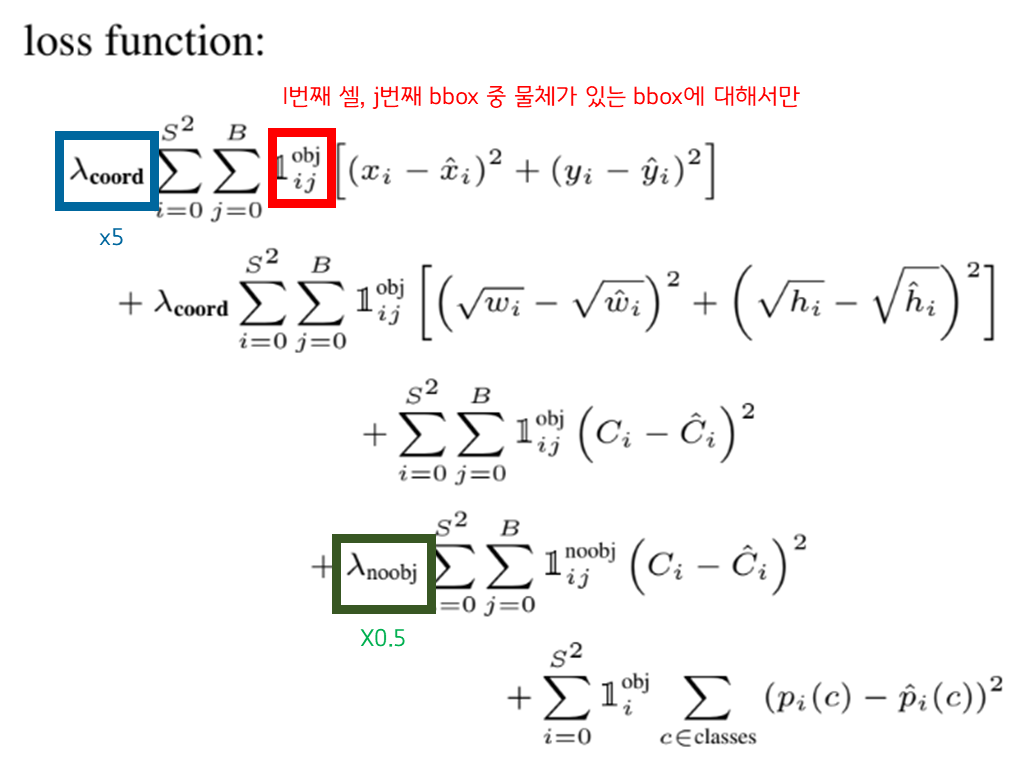

#### tensorflow method 정리
- tf.reshape(대상, shape) : 대상을 shape으로 reshape
- tf.concat([a, b], axis) : a, b를 axis 기준으로 병합
- tf.expand_dims(대상, axis) : 대상을 axis 기준으로 차원 추가  
  
  

```
예) 아래처럼 변형하고 싶다면?  
  [[1, 2, 3], [4, 5, 6]] : shape=(2, 3) -> [[[1, 2, 3], [4, 5, 6]]] : shape=(1, 2, 3)

  tf.expand_dims(대상, axis=0)
```

- tf.reduce_sum(대상, axis) : 대상을 axis기준으로 sum 계산 리턴


In [ ]:
def loss(predictions, target):
    S = 7 # 차원 7*7
    B = 2 # 바운딩 박스 수
    C = 20 # 클래스 수
    lambda_noobj = 0.5
    lambda_coord = 5

    predictions = tf.reshape(predictions, [-1, S, S, C + B * 5])
    ## predictions shape : -1x7x7x30 (-1은 배치사이즈)
    ## 채널 30(0~29) 설명 : (주의) 채널의 순서가 수업자료와 상이함.
    ### 그리드 당 정답은 7*7*25라서 정답값과 맞추려고 편의상 변경
        # 0~19 -> class prediction
        # 20, 25 -> confidence
        # 21~24, 26~29 -> bbox coord

    # 각 그리드 별로 bbox1, bbox2 각각 target과의 iou 계산(둘 중 iou가 높은 값을 채택하기 위함)
    # ..., : 앞의 채널 의미(7*7)
    iou_b1 = iou(predictions[..., 21:25], target[..., 21:25]) # bbox1와 target 간의 iou
    iou_b2 = iou(predictions[..., 26:30], target[..., 21:25]) # bbox2와 target 간의 iou
    ## expand_dims : numpy 배열 확장(axis에 입력된 값으로 차원 추가)
    ### 2*7*7*1(1이 iou)
    ious = tf.concat([tf.expand_dims(iou_b1, 0), tf.expand_dims(iou_b2, 0)], axis=0)

    # 각 그리드 별로 큰 IOU 값 추출
    ## reduce_max : 둘 중 큰 값 출력
    iou_maxes = tf.math.reduce_max(ious, axis=0)

    # 그에 해당하는 bestbox indices 저장 (0:first bbox, 1:second bbox)
    ## argmax : 큰 값의 인덱스 알려준다, 큰 값이 어느 bbox인지 기록용
    bestbox = tf.math.argmax(ious, axis=0)

    # target matrix의 confidence -> 물체유무 값(0, 1)
    exists_box = tf.expand_dims(target[..., 20], axis=-1)

    ############################################################################
    # Box LOSS (답 제공)
    box_predictions = exists_box * (
        bestbox * predictions[..., 26:30] +
        (1 - bestbox) * predictions[..., 21:25]
    )
    box_targets = exists_box * target[..., 21:25]

    ## width & height - sqrt 적용
    ## sqrt:  스퀘어 루트 씌우는 것, 정답 bbox와 예측 bbox 간의 차이를 비율로 파악 위함
    # 절대 값으로 빼면 크기차이가 달라도 비슷한 loss가 됨
    box_predictions[..., 2:4] = tf.sqrt(box_predictions[..., 2:4])
    box_targets[..., 2:4] = tf.sqrt(box_targets[..., 2:4])

    # metrix의 각 채널의 동일한 위치에 있는 값을 빼서 제곱 (x, y, w, h)
    ## w, h는 위의 코드에서 루트 씌운 값으로 덮어씌워짐
    box_loss = tf.reduce_sum(tf.square(box_predictions - box_targets))
    # 7 * 7 * 4
    ############################################################################
    # (여기부터 작성해보세요)
    ############################################################################
    # OBJECT LOSS
    pred_box = (
        bestbox * predictions[..., 25:26] +
        (1 - bestbox) * predictions[..., 20:21]
    )

    confidence_target = exists_box * iou_maxes
    object_loss = tf.reduce_sum(tf.square(exists_box * (pred_box - confidence_target)))

    # NO-OBJECT LOSS
    no_object_loss = tf.reduce_sum(tf.square((1 - exists_box) * predictions[..., 20:21]))
    no_object_loss += tf.reduce_sum(tf.square((1 - exists_box) * predictions[..., 25:26]))

    # CLASS LOSS
    class_loss = tf.reduce_sum(tf.square(exists_box * predictions[..., :20] - target[..., :20]))

    # TOTAL LOSS
    loss = (
        lambda_coord * box_loss +
        object_loss +
        lambda_noobj * no_object_loss +
        class_loss
    )
    ############################################################################

    return loss
